In [1]:
# Make sure that you have all these libaries available to run the code successfully
# from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('Stock_Markets.csv')
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Stock
0,2/21/2023,204.990005,209.710007,197.220001,197.369995,197.369995,180018600,TSLA
1,2/22/2023,197.929993,201.990005,191.779999,200.860001,200.860001,191828500,TSLA
2,2/23/2023,203.910004,205.139999,196.330002,202.070007,202.070007,146360000,TSLA
3,2/24/2023,196.330002,197.669998,192.800003,196.880005,196.880005,142228100,TSLA
4,2/27/2023,202.029999,209.419998,201.259995,207.630005,207.630005,161028300,TSLA


In [4]:
def get_stock_data(df, stock, normalized=0):
    # df = df[df.Stock == stock]
    df = pd.read_csv('AAL.csv')
    df = df.dropna()

    df = df.drop(columns=['Adj Close', 'Volume'])
    # df["Volume"] = df["Volume"] / 10000
    # df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1) 
    return df

In [5]:
# stock = input("Enter stock name: ")
stock = 'TSLA'

df = get_stock_data(df, stock, 0)

# Checking if any data was found for the specified stock
if not df.empty:
    print("Data Retrieved")
else:
    print(f"No Data Found For {stock}.")

df.head()
df.shape


Data Retrieved


(4534, 5)

In [6]:
# df.to_csv('Stock_Markets_TSLA.csv', index=False)

In [7]:
# df = df.drop(columns=['Stock'])

In [8]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,2005-09-27,21.049999,21.400000,19.100000,19.299999
1,2005-09-28,19.299999,20.530001,19.200001,20.500000
2,2005-09-29,20.400000,20.580000,20.100000,20.209999
3,2005-09-30,20.260000,21.049999,20.180000,21.010000
4,2005-10-03,20.900000,21.750000,20.900000,21.500000


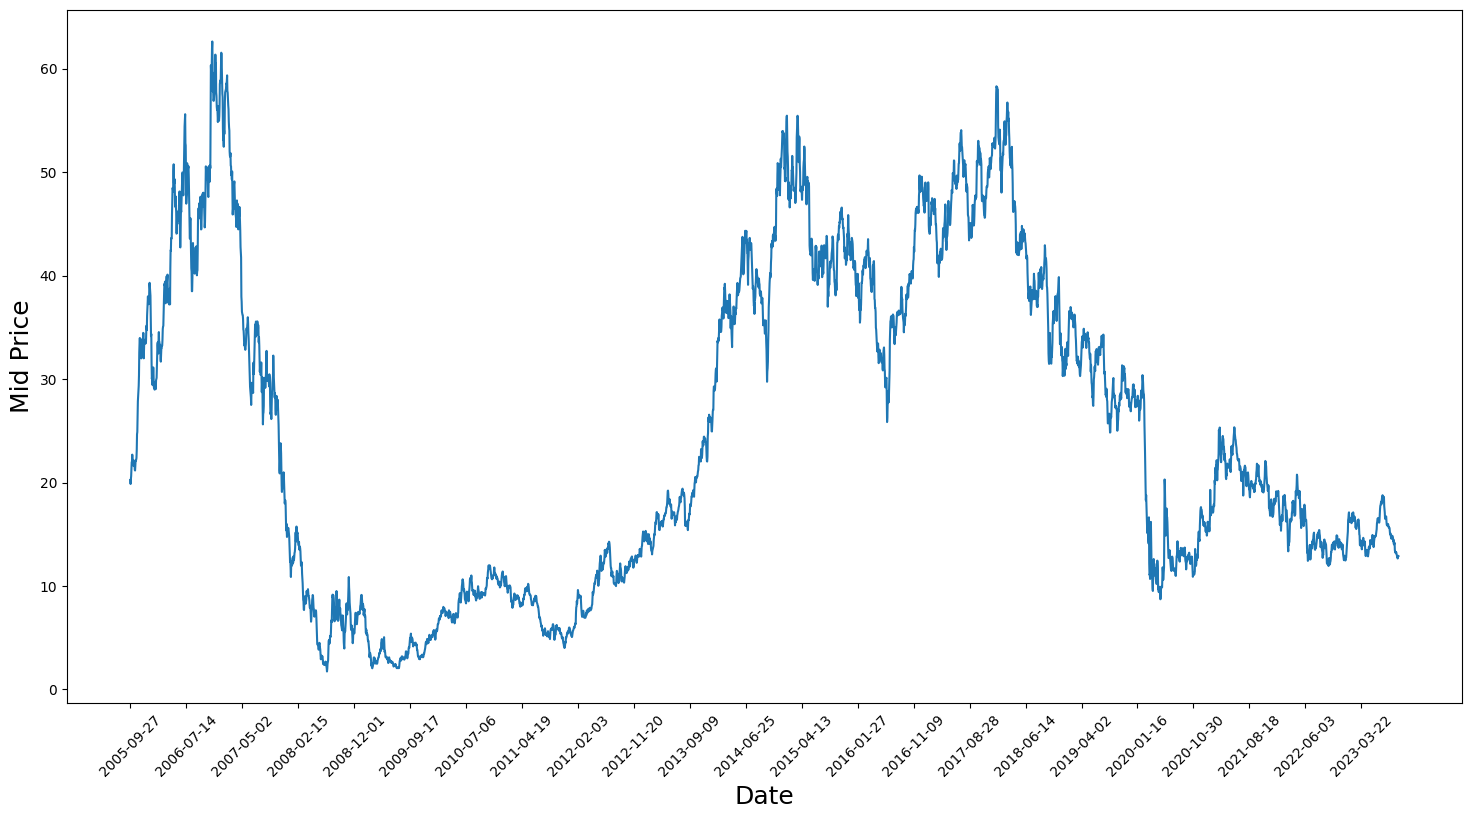

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [10]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [11]:
# calculate the index where the list is split
index = int(len(mid_prices) * 0.7)

# assign 70% of data to train_data
train_data = mid_prices[:index]

# assign 30% of data to test_data
test_data = mid_prices[index:]

In [12]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [13]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,60,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [14]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2600):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

### Calculating The Mean Squared Error For Standard Averaging Model.

In [15]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00177


In [16]:
mid_prices

array([1.97993844e-03, 1.78194460e-03, 4.04653253e-03, ...,
       1.28250000e+01, 1.28600000e+01, 1.28900000e+01])

This code implements a simple stock price prediction method using a rolling window and calculates the Mean Squared Error to evaluate the accuracy of the predictions. The result is a measure of how well the standard averaging technique performed in predicting stock prices.

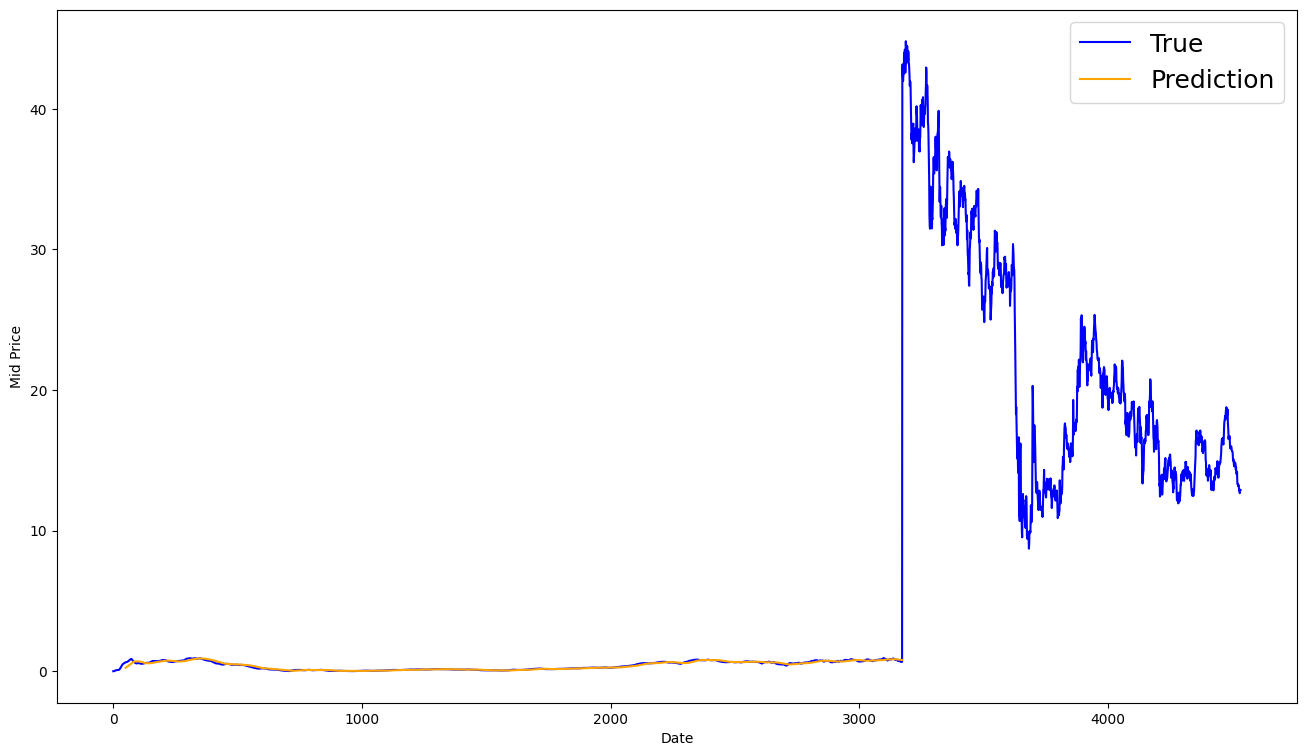

In [17]:
plt.figure(figsize = (16,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [18]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00005


In [19]:
df.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

In [20]:
N

3173

In [21]:
# import numpy as np

# # Example of inconsistent data
# run_avg_predictions = [[1, 2, 3], [4, 5], [6, 7, 8]]

# # Check for inconsistent elements
# inconsistent = any(len(item) != len(run_avg_predictions[0]) for item in run_avg_predictions)

# if inconsistent:
#     print("Data is inconsistent. Please clean the data.")
# else:
#     # Convert the list to a 1D NumPy array
#     run_avg_predictions_array = np.array(run_avg_predictions)
#     print("Data converted to a 1D NumPy array successfully.")

In [22]:
run_avg_predictions

[0.0,
 array([0.00098997]),
 array([0.00138596]),
 array([0.00271624]),
 array([0.00510757]),
 array([0.00968247]),
 array([0.01666975]),
 array([0.02454752]),
 array([0.03415493]),
 array([0.04277463]),
 array([0.05050602]),
 array([0.05707825]),
 array([0.06227312]),
 array([0.06595845]),
 array([0.07013019]),
 array([0.0740808]),
 array([0.07719439]),
 array([0.07823282]),
 array([0.07813124]),
 array([0.07893597]),
 array([0.0812397]),
 array([0.0840128]),
 array([0.0871156]),
 array([0.09062303]),
 array([0.09607856]),
 array([0.10609783]),
 array([0.11820981]),
 array([0.13519636]),
 array([0.15661276]),
 array([0.18032744]),
 array([0.20522773]),
 array([0.23056077]),
 array([0.25743183]),
 array([0.28928271]),
 array([0.32414762]),
 array([0.35991126]),
 array([0.39270978]),
 array([0.42321547]),
 array([0.45184551]),
 array([0.47746717]),
 array([0.49633981]),
 array([0.51165604]),
 array([0.52653458]),
 array([0.54057509]),
 array([0.55473214]),
 array([0.56730809]),
 array([

In [23]:
run_avg_predictions = np.array(run_avg_predictions, dtype=object)

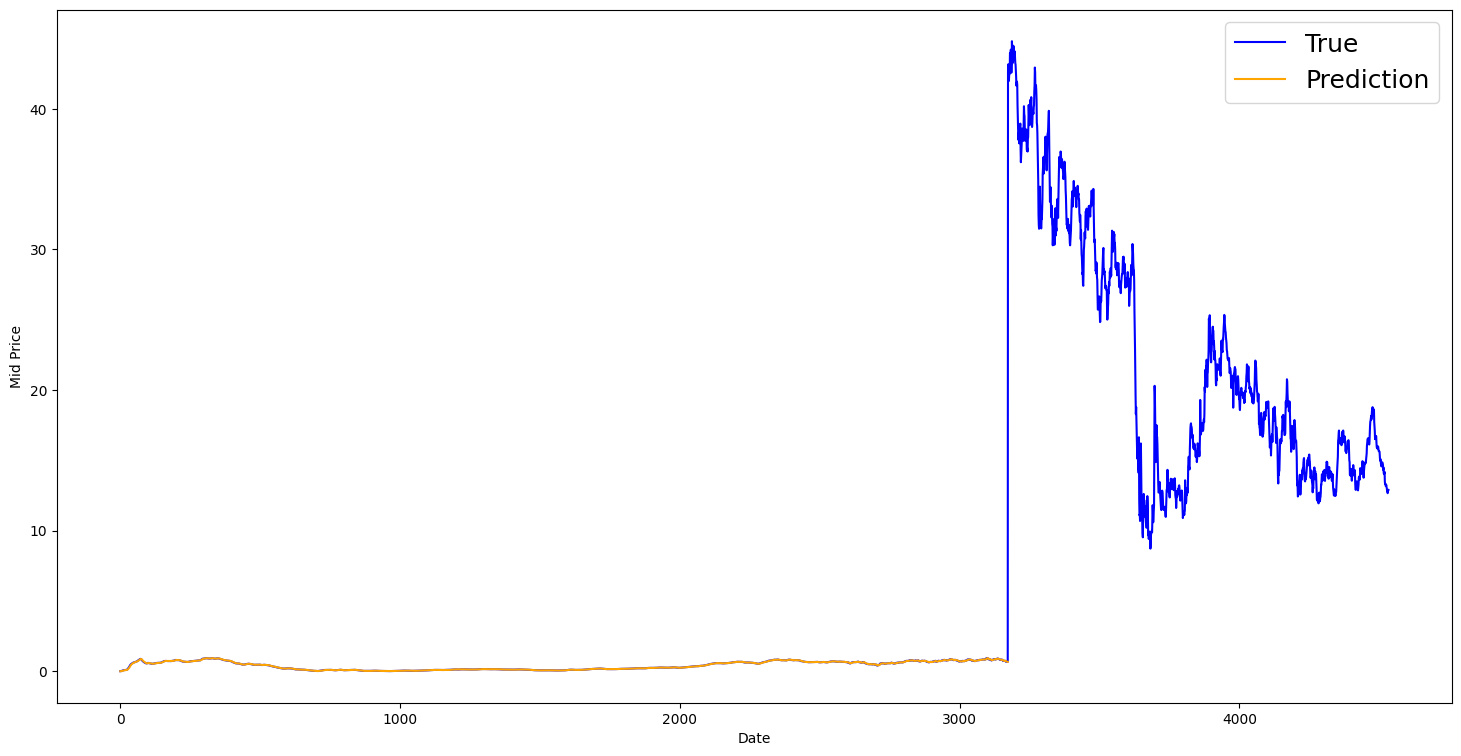

In [24]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,3173),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [25]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00197994 0.1274373  0.12258337 0.23363295 0.65762323]

	Output: [0.00178194 0.1274373  0.12258337 0.23447055 0.65762323]


Unrolled index 1
	Inputs:  [0.00178194 0.1274286  0.12246068 0.2340565  0.6625974 ]

	Output: [0.00404653 0.12594189 0.12246068 0.23393264 0.67552954]


Unrolled index 2
	Inputs:  [0.00404653 0.1277492  0.12226815 0.23447055 0.66677856]

	Output: [0.0074989  0.1277492  0.12238225 0.23447055 0.66677856]


Unrolled index 3
	Inputs:  [0.0074989  0.12742195 0.12238225 0.23451474 0.67144483]

	Output: [0.04376234 0.12664297 0.12489422 0.23510331 0.6890525 ]


Unrolled index 4
	Inputs:  [0.01425737 0.12664297 0.12333886 0.23407009 0.67552954]

	Output: [0.02365703 0.12594189 0.12583776 0.2357411  0.6890525 ]


C:\Users\demon\AppData\Local\Temp\ipykernel_1660\2906622577.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  batch_data[b] = self._prices[self._cursor[b]]
C:\Users\demon\AppData\Local\Temp\ipykernel_1660\2906622577.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]


In [27]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

# Use tf.compat.v1.reset_default_graph() instead of tf.reset_default_graph()
# This is compatible with both TensorFlow 1.x and 2.x
tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

In [32]:
tf.compat.v1.disable_eager_execution ()

# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    # Use tf.compat.v1.placeholder() instead of tf.placeholder()
    # This is compatible with both TensorFlow 1.x and 2.x
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))